In [ ]:
#Imports
import os
import sys
import glob
import torch
import torchvision

import numpy    as np
import datetime as dt
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot   as plt

from PIL               import Image
from torch.utils.data  import Dataset
from torch.autograd    import Variable
from torch.optim       import lr_scheduler

from torch.utils.data  import WeightedRandomSampler, Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision       import transforms, datasets, models
from os                import listdir, makedirs, getcwd, remove
from os.path           import isfile, join, abspath, exists, isdir, expanduser

from torch import optim

# %matplotlib inline

In [ ]:
# This assume that the data is contained in a google drive, you can modify this according to where your data is stored
###########################################################################################
###########################################################################################
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/MyDrive/ammi-2021-convnets"
train_path = join(data_path, "train/train")
test_path = join(data_path,"test/test")
extraimage_path = join(data_path, "extraimages/extraimages")
###########################################################################################
###########################################################################################


In [ ]:
###########################################################################################
################# Transformations for both the training and testing data ##################
###########################################################################################
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

normalize = transforms.Normalize(mean=mean, std=std)

# Do data transforms here, you can try many others
train_transforms = transforms.Compose([transforms.Resize(448),
                                       #transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomResizedCrop(448),
                                       transforms.ToTensor(),
                                       normalize,
                                      #  transforms.RandomErasing(),
                                      ])

test_transforms = transforms.Compose([ 
                                        transforms.Resize(448),
                                       #transforms.RandomRotation(30),
                                      #  transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(448),
                                       transforms.ToTensor(),
                                       normalize,
                                     ])
###########################################################################################
###########################################################################################
###########################################################################################


In [ ]:
###########################################################################################
############################# Dataset Class and data loading ##############################
###########################################################################################
class CassavaDataset(Dataset):
    def __init__(self, path, transform=None):
        self.classes = os.listdir(path)
        self.path = [f"{path}/{className}" for className in self.classes]
        self.file_list = [glob.glob(f"{x}/*") for x in self.path]
        self.transform = transform

        files = []
        for i, className in enumerate(self.classes):
            for fileName in self.file_list[i]:
                files.append([i, className, fileName])
        self.file_list = files
        files = None

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fileName = self.file_list[idx][2]
        classCategory = self.file_list[idx][0]
        im = Image.open(fileName)
        if self.transform:
            im = self.transform(im)
            
        return im.view(3, 448, 448), classCategory
        

In [ ]:
# Load the train and test set on a pytorch dataset object
train_data = CassavaDataset(train_path, transform=train_transforms)
test_data = CassavaDataset(test_path, transform=test_transforms)
print(f"size of training {len(train_data)}")
print(f"size of testing {len(test_data)}")


size of training 5656
size of testing 3774


In [ ]:
# split the data into training and validation.
import random
validation_split = .2
shuffle_dataset = True
random_seed= 42
BATCH_SIZE = 16

torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

# Creating data indices for training and validation splits:
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]


In [ ]:
# Creating pytorch data samplers and loaders:
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,
                                             sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,
                                             sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [ ]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device: {device}")
###########################################################################################
###########################################################################################
###########################################################################################


device(type='cuda', index=0)

In [ ]:
def train(model, criterion, data_loader, valid_loader, optimizer, num_epochs, fixed_params_epochs = -1):
    """
    This Method runs the optimization loop for learning the parameters
    Method parameters:
    model: the model object.
    criterion: the loss function.
    data_loader: training data loader object.
    valid_loader: validation data loader object.
    optmizer: the optimizer object.
    num_epochs: number of training epochs.
    The function returns: 
    losses: a list that containes the loss for every epoch.
    training_accuracies: a list that containes the traning accuracy for every epoch.
    validation_accuracies: a list that containes the validation accuracy for every epoch.
    """
    # Move model to the device (CPU or GPU).
    model = model.to(device)
    
    # Exponential moving average of the loss.
    ema_loss = None

    # Losses list 
    losses = []
    # training accuracy list
    training_accuracies = []
    # valid accuracy list
    valid_accuracies = []

    print('----- Training Loop -----')
    # Loop over epochs.
    for epoch in range(num_epochs):
      # check the number of epochs to enable the gradient of the fearure extracter
      if epoch > fixed_params_epochs:
        for param in model.parameters():
          param.requires_grad = True
      # Make sure model is in training mode.
      model.train()  
      correct = 0
      # Loop over data.
      for batch_idx, (features, target) in enumerate(data_loader):
        # Forward pass.
        output = model(features.to(device))
        loss = criterion(output, target.to(device))
        
        # Backward pass.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute the training accuracy
        with torch.no_grad():
          pred = output.argmax(dim=1, keepdim=True)
              
          # Count number of correct predictions.
          correct += pred.cpu().eq(target.view_as(pred)).sum().item()
      
      # NOTE: It is important to call .item() on the loss before summing.
        if ema_loss is None:
            ema_loss = loss.item()
        else:
            ema_loss += (loss.item() - ema_loss) * 0.01

      # Print out progress the end of epoch.
      lr_sch.step()
      train_score = 100. * correct / len(data_loader.sampler)
      # Compute the validation accuracy
      valid_score = test(model, valid_loader)
      losses.append(ema_loss)
      training_accuracies.append(train_score)
      valid_accuracies.append(valid_score)
      print('Epoch: {} \tLoss: {:.12f} \tTraining Accuracy: {:.12f} \t Validation Accuracy: {:.12f}'.format(epoch, ema_loss, train_score, valid_score),)

    return losses, training_accuracies, valid_accuracies
  

In [ ]:
def test(model, data_loader, batch_size):
    """
    This Method runs measure the model accuracy on a given dataset
    Method parameters:
    model: the model object.
    data_loader: training data loader object.
    The function returns: 
    percent: the model accuracy
    """ 
    # Make sure the model is in evaluation mode.
    model.eval()
    correct = 0
    # print('----- Model Evaluation -----')
    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():
        # Loop over test data.
        # torch.manual_seed(random_seed)
        for features, target in data_loader:
          
            # Forward pass.
            output = model(features.to(device))
            
            # Get the label corresponding to the highest predicted probability.
            pred = output.argmax(dim=1, keepdim=True)
            
            # Count number of correct predictions.
            correct += pred.cpu().eq(target.view_as(pred)).sum().item()

    # Print test accuracy.
    percent = 100. * correct / len(data_loader.sampler)
    # print(f'Test accuracy: {correct} / {len(data_loader.dataset)} ({percent:.0f}%)')
    torch.save(model.state_dict(), 'model.ckpt')
    return percent
    

In [ ]:
def plot(training_loss, training_score, valid_score):
    """
    Plot the model training metrics.
    Method parameters:
    training_loss: a list that containes the loss for every epoch.
    training_score: a list that containes the training accuracy for every epoch.
    valid_score: a list that containes the validation accuracy for every epoch.
    """
    epochs = range(1, len(training_loss)+1)
    plt.title("Training Loss")
    plt.plot(epochs, training_loss)
    plt.xlabel("Epochs")
    plt.ylabel("Training loss")

    plt.figure()
    plt.plot(epochs, training_score, label="Train")
    plt.plot(epochs, valid_score, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
###########################################################################################
###########################################################################################
###########################################################################################


# ResNext50

In [ ]:
###########################################################################################
############### Train a pretrained resnext50 model on the whole data set ##################
###########################################################################################
torch.manual_seed(random_seed) # fix the random seed
model = torchvision.models.resnext50_32x4d(pretrained=True)

# for param in model.parameters():
#     param.requires_grad = False

# set the final linear layer to the number of classes of the problem
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=3e-3)
# a cosine Learning rate scheduler
lr_sch = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0, last_epoch=-1, verbose=False)
num_epochs = 7
losses, train_score, valid_score= train(model, criterion, train_loader, valid_loader ,optimizer, num_epochs)
# Best validation accuecay was about 89.8% while the training accuracy was 91.2%, the model is overfitting

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth



----- Training Loop -----
Epoch: 0 	Loss: 0.664435334949 	Training Accuracy: 77.657458563536 	 Validation Accuracy: 86.472148541114
Epoch: 1 	Loss: 0.502599893240 	Training Accuracy: 83.226519337017 	 Validation Accuracy: 85.499557913351
Epoch: 2 	Loss: 0.455088780058 	Training Accuracy: 85.038674033149 	 Validation Accuracy: 84.969053934571
Epoch: 3 	Loss: 0.416408500815 	Training Accuracy: 86.276243093923 	 Validation Accuracy: 89.566755083996
Epoch: 4 	Loss: 0.347589594843 	Training Accuracy: 88.353591160221 	 Validation Accuracy: 88.505747126437
Epoch: 5 	Loss: 0.343553224517 	Training Accuracy: 88.419889502762 	 Validation Accuracy: 88.594164456233
Epoch: 6 	Loss: 0.272513266564 	Training Accuracy: 91.204419889503 	 Validation Accuracy: 89.832007073386


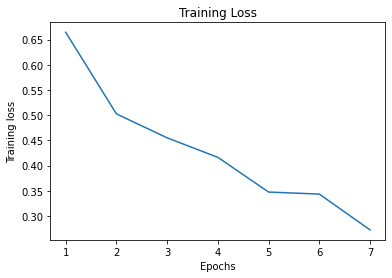

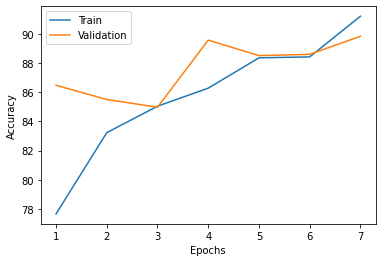

In [ ]:
plot(losses, train_score, valid_score) # plot the training dynamics
###########################################################################################
###########################################################################################

In [ ]:
# A dictionary that maps the labels to the classes names
classes_dict = {i:class_ for i, class_ in zip(range(5), train_data.classes)}

{0: 'cgm', 1: 'cbsd', 2: 'healthy', 3: 'cbb', 4: 'cmd'}

In [ ]:
# precition function
def predict(model, test_loader):
  model.eval()
  with torch.no_grad():
    preds = []
    # i = 0
    for img, label in test_loader:
      # i += 1
      outputs = model(torch.unsqueeze(img.to(device=device), dim=0))
      pred = torch.argmax(outputs, dim=1)
      preds.append(classes_dict[pred.item()])
  return preds

In [ ]:
model = torchvision.models.resnext50_32x4d(pretrained=True) # define your model architecture
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model = model.to(device)

model.load_state_dict(torch.load("model.ckpt")) # load the saved model state, which includes the final parameters
preds = predict(model, test_data) 

In [ ]:
filenames = [filename[2].split('/')[-1] for filename in test_data.file_list] # extract the filenames

In [ ]:
# make a submission file in the current directory
import pandas as pd
submission = (pd.DataFrame.from_dict({'Category': preds,'Id': filenames}))
sub_file = "first_submission.csv"
submission.to_csv(sub_file, header=True, index=False)